# Spot Checking Models and Advanced Pipelines with Hyperparameter Tuning (Classification)
**OPIM 5512: Data Science Using Python - University of Connecticut**

---------------------------------
Now that you are a pro at regression spot checking, hyperparameter tuning and pipelines for standardizing pipelines - let's apply everything we know to regression.

Instead of Boston Housing, we will use the Wisconsin Breast Cancer dataset.

# Import Modules

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# classification spot check models!
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# more advanced ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

# Read Data

In [ ]:
# let's use gdown to get the data instead of mounting the drive
# https://drive.google.com/file/d/1UwCOmgdOwvpMd58lVlwqUL3w1IRaYJa-/view?usp=sharing
!gdown 1UwCOmgdOwvpMd58lVlwqUL3w1IRaYJa-

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UwCOmgdOwvpMd58lVlwqUL3w1IRaYJa-
To: /content/breastcancer.csv
100% 125k/125k [00:00<00:00, 80.1MB/s]


In [ ]:
df = pd.read_csv('breastcancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


The target variable will be `diagnosis`. Let's drop that last unnamed column while we are here. And since `id` doesn't have predictive power, let's drop that too.

In [ ]:
df.drop('Unnamed: 32', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.columns # voila - it's gone!

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df.info() # check for any missing values - all looks good!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

If you look at the unique values in the `diagnosis`, we see that these are... **M** for malignant and **B** for benign.



In [ ]:
Counter(df['diagnosis'])

Counter({'M': 212, 'B': 357})

Our data is imbalanced, and we will ignore this for now - we can use SMOTE later on with an imblearn Pipeline (different than an sklearn pipeline - be careful!) So

So that we don't have to deal with problems in a logistic regression, let's use `LabelEncoder()` from `sklearn`.

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['diagnosis'] = LE.fit_transform(df['diagnosis'])
Counter(df['diagnosis'])

Counter({1: 212, 0: 357})

As you can see, B is 0 and M is 1. You could use SMOTE now before all of your pipelines (if you wanted to use it for everything). But for now, we simply ignore the class balance.

# Data Visualization
This is the same code as before - do you see the power of the pandas dataframe? Do you see the code modularity? Do you agree that coding is a lot like following a recipe?

## Histograms
Instead of going one by one through the columns on a new dataset, you can show them all at once (assuming you don't have too many.)

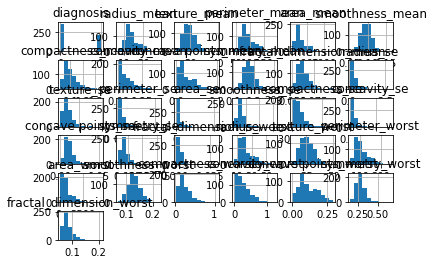

In [ ]:
# histograms
df.hist()
plt.rcParams["figure.figsize"] = (40,40) # a nice way of specifying dimensions after the image is drawn!
plt.show()

# try (5,5), (10,10) and (20,20) to see which image size you like best!

## Density Plots
Be careful with the layout argument - will be different for every dataset!

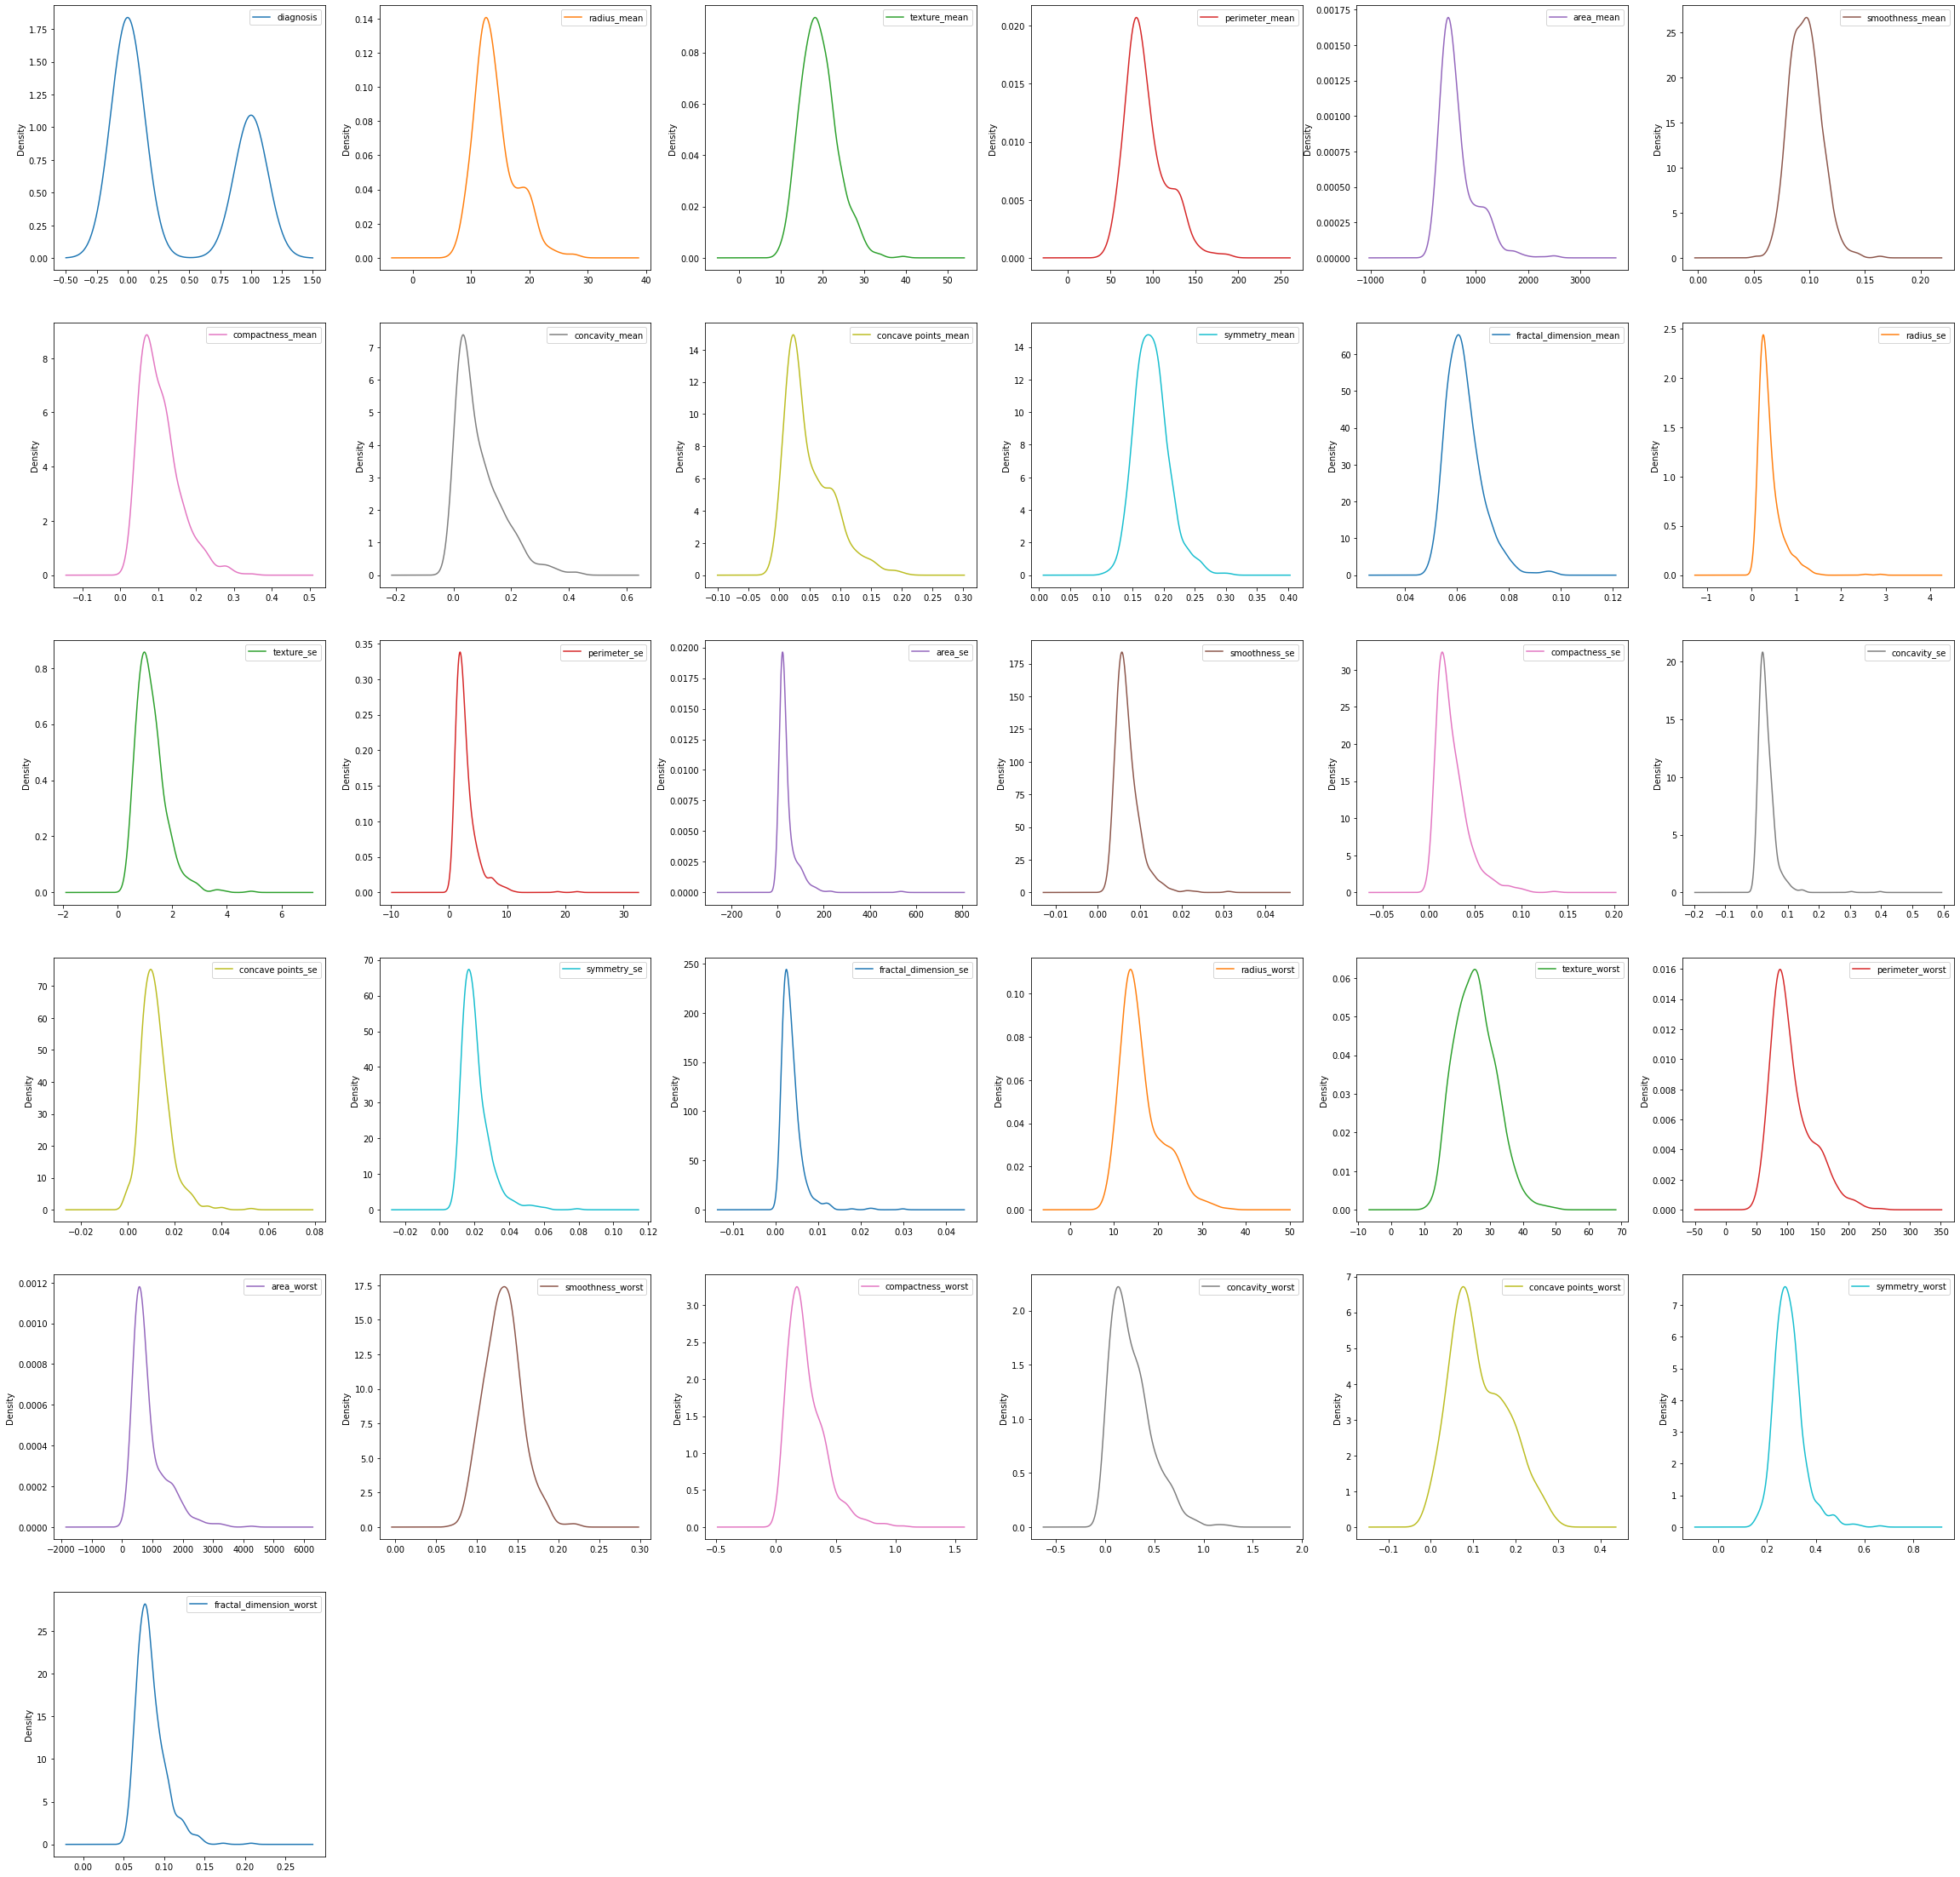

In [ ]:
# kernel density plots

df.plot(kind='density', subplots=True, layout=(6,6), sharex=False)
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

## Boxplots

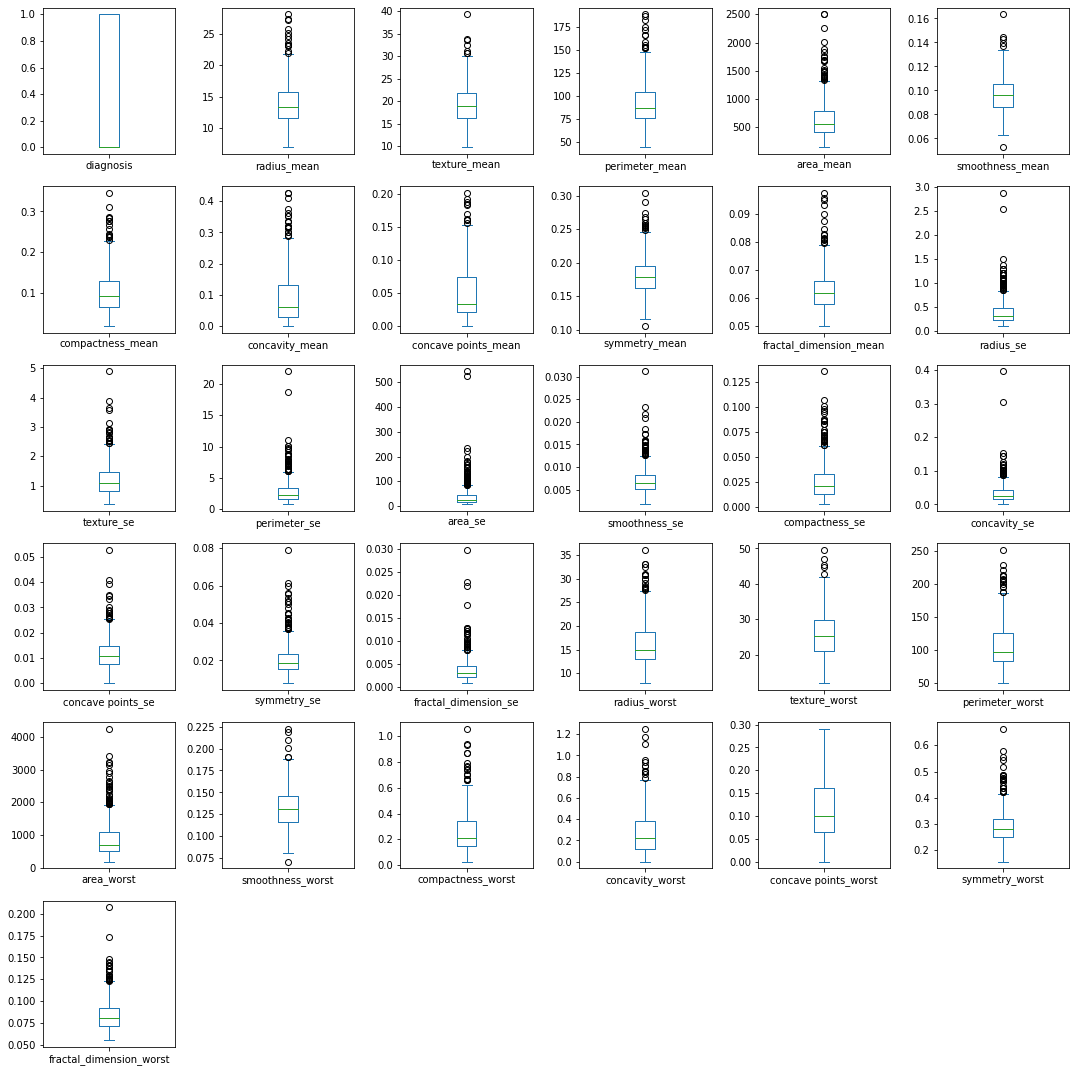

In [ ]:
# boxplots
df.plot(kind='box', subplots=True, layout=(6,6), sharex=False, sharey=False)
plt.rcParams["figure.figsize"] = (15,15)
plt.tight_layout() # for some room!
plt.show()

We won't look at the correlation matrix or scatterplot matrix.

# Prepare Data for Modeling (Split, CV, error metrics)
At this point you are ready to:
* Split into X and y
* Make a train and test partition
* Leverage 10-fold cross-validation
* Add a seed for reproducability
* Make a list of all of the models you are interested in evaluating

In [ ]:
# Split-out validation df
X = df.drop('diagnosis', axis=1) #covariates - just drop the target!
y = df['diagnosis'] #target variable
validation_size = 0.20
seed = 123 # so you will split the same way and evaluate the SAME dataset

# split!
X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                    test_size=validation_size,
                                                    random_state=seed)

# What Are Some Good 'Spot Checking' Models? (Classification)
The main 'spot checking' models for regression are:
* Logistic Regression
* Decision Tree Classifier (DTC)
* k-Nearest Neighbor (KNN)
* Gasussian Naive Bayes

These are simple estimators - they run quickly and are relatively easy to explain to your boss.

In [ ]:
####################################################
# Spot-Check Algorithms
# for spot-checking, you generally accept defaults - just looking for a basic feel
# of whether or not you have predictive data...

models = []
models.append(('LR', LogisticRegression(max_iter=100000000))) # sometimes, for spot checking, you need to up the iterations!
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [ ]:
##################################################
# evaluate each model in turn
results = []
names = []

for name, model in models:
	kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.944831 (0.030301)
KNN: 0.920870 (0.014534)
CART: 0.921014 (0.038109)
NB: 0.933816 (0.039865)


Remember - your cross-validation is only based on the training data! You still need to evaluate your model on the test partition. And look, the mean is not necessarily the only thing to look at - you have a distribution of results!

**On Your Own:** do you get different results when you do a 10-fold vs. a 100-fold validation? If so, is this bad? Warning - the 100-fold model will take 10x longer to fit.

# Evaluate and Compare the Algorithms
It is not only useful to look at the mean value, but also the distribution. Given the tightness of the boxplot, I'd probably go with Naive Bayes here! Your results might be slightly different due to randomness.

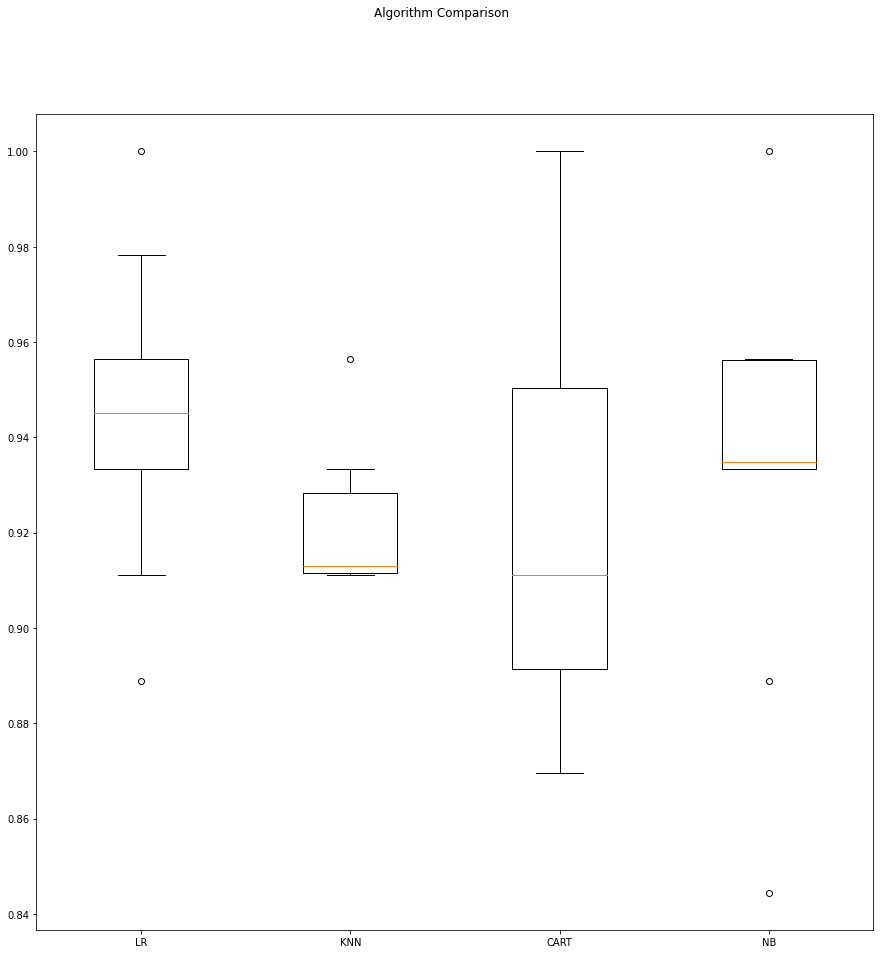

In [ ]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.suptitle('Algorithm Comparison')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

And Naive Bayes really has no hyperparameters to tune - so you would be done here. Let's try some other models and see if they can crush Naive Bayes - we will run all of these models with some pre-processing.

# Pipelines with Ensemble Methods
Remember - what's the benefit of a pipeline, anyway? It's the inclusion of the pre-processing (like scaling or PCA) directly in the pipeline. We still aren't doing hyperparameter tuning just yet, but we will soon.

This is still a pipeline - we have just named our list `ensembles` instead of `pipeline`. Notice that the `Pipeline()` function is inside each append statement.

You can tinker with ANY NUMBER of algorithms! Here are a few you may consider:
* AdaBoost Regressor
* Gradient Boosting Regressor (you have some experience with this one!)
* Random Forest Regressor (this one too!)
* Extra Trees Regressor

And we will add our other tree models here as well - they all can live together since they run fast!

In [ ]:
AdaBoostClassifier

sklearn.ensemble._weight_boosting.AdaBoostClassifier

ScaledLR: 0.973527 (0.023882)
ScaledKNN: 0.964734 (0.022458)
ScaledDT: 0.916618 (0.042594)
ScaledAda: 0.975749 (0.015448)
ScaledGBM: 0.966957 (0.024719)
ScaledRF: 0.949372 (0.031273)
ScaledET: 0.955990 (0.017158)


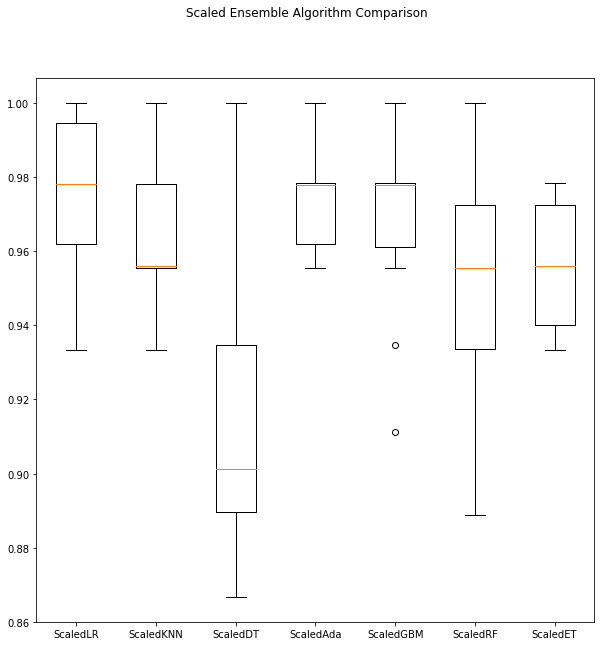

In [ ]:
# ensembles
ensembles = []
ensembles.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
ensembles.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('LASSO', KNeighborsClassifier())])))
ensembles.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('EN', DecisionTreeClassifier())])))
ensembles.append(('ScaledAda', Pipeline([('Scaler', StandardScaler()),('ADA', AdaBoostClassifier())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])))

results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=10, random_state=123, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Interesting! So AdaBoost (a varient of gradient boosting) seems to have done well. You could tinker and do the tuning on one model...

In [ ]:
# let's make sure we scale X_train and y_train before we fit (our pipeline did that before)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


You need to look at the tuneable hyperparameters for each model when building your grid. Use the exact name in your dictionary, and make sure your candidate values are in a list [like this, like this].

In [ ]:
# Tune scaled AdaBoost

# let's try curley brackets this time!
# AND, let's tune more than one thing
param_grid = {'n_estimators':[50,100,150,200,250,300,350,400],
              'learning_rate': [0.005, 0.001, 0.01]}

model = AdaBoostClassifier(random_state=seed)
kfold = KFold(n_splits=10, random_state=123, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.953671 using {'learning_rate': 0.01, 'n_estimators': 400}
0.907778 (0.018708) with: {'learning_rate': 0.005, 'n_estimators': 50}
0.920918 (0.035387) with: {'learning_rate': 0.005, 'n_estimators': 100}
0.927440 (0.032553) with: {'learning_rate': 0.005, 'n_estimators': 150}
0.927488 (0.036601) with: {'learning_rate': 0.005, 'n_estimators': 200}
0.925362 (0.041535) with: {'learning_rate': 0.005, 'n_estimators': 250}
0.925314 (0.036749) with: {'learning_rate': 0.005, 'n_estimators': 300}
0.931884 (0.033051) with: {'learning_rate': 0.005, 'n_estimators': 350}
0.934058 (0.030959) with: {'learning_rate': 0.005, 'n_estimators': 400}
0.887971 (0.030110) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.885749 (0.027376) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.890097 (0.029696) with: {'learning_rate': 0.001, 'n_estimators': 150}
0.907778 (0.018708) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.907778 (0.018708) with: {'learning_rate': 0.001, 'n_estimators': 250}


Note that this will take a long time because you are fitting 24 models! After this, you should test your BEST model on the test partition.

In [ ]:
# Make predictions on validation df

# recall that we already did our scaling of the test and train partition early on

# prepare the model
model = AdaBoostClassifier(random_state=123, n_estimators=400, learning_rate=0.01)
model.fit(X_train, Y_train)
test_preds = model.predict(X_test)
print(accuracy_score(Y_test, test_preds))

0.9824561403508771


98% on the test partition! We know that we can do better than just tuning one model. Let's try tune all 7 of these algorithms.

Pause for a moment and look at the documentation for each of these models:
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
* [GBM](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Extra Trees ](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

Then, go build a pipeline where you tune all the hyperparameters. And get a cup of coffee while it all runs! We will do this in the next notebook.
